In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.dataset import PreloadedDataset
from utils.train import train_denoise
from utils.extra_funcs import HopfieldActivation
from model import HopfieldNetwork

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
DATA_RATIO = 0.005 # portion of dataset to use
VAL_RATIO = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    HopfieldActivation(0.5), # set images to -1 or 1
    # transforms.Normalize((0.1307,), (0.3081,)),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
])

dataset = datasets.MNIST(root="datasets/", train=True, transform=transform, download=True)
# reduce dataset size
dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * DATA_RATIO)))
# dataset = torch.utils.data.Subset(dataset, range(4))

val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transforms.ToTensor(), device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10
print(f'INPUT_SHAPE: {INPUT_SHAPE}')
print(f'Loaded MNIST dataset with {len(train_dataset)} training samples')#and {len(val_dataset)} validation samples')

INPUT_SHAPE: torch.Size([1, 28, 28])
Loaded MNIST dataset with 240 training samples


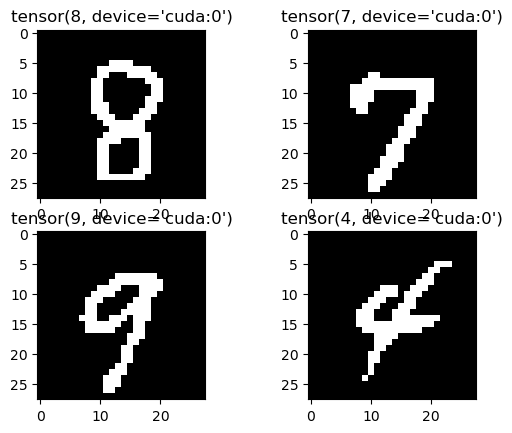

In [5]:
# Show 4 random images from the training dataset in grid
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        idx = torch.randint(0, len(train_dataset), (1,)).item()
        image = train_dataset[idx][0].squeeze().cpu()
        ax[i, j].imshow(image, cmap="gray")
        ax[i, j].set_title(train_dataset[idx][1])
plt.show()


In [6]:
# Hebbian Learning
torch.manual_seed(42)
model_name = "mnist_hopfield_hebbian"
size = 1
for dim in INPUT_SHAPE:
    size *= dim
model = HopfieldNetwork(size, bias=False, steps=5).to(device)
step = 0

In [7]:
LR = 3e-3
BATCH_SIZE=64
epochs = 5000
criterion = nn.MSELoss()
optimiser = optim.AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimiser, mode='min', min_lr=3e-9, factor=0.5, patience=50, verbose=True)
energy, step = train_denoise(model, 
                             train_dataset, 
                             val_dataset, 
                             optimiser, 
                             scheduler, 
                             model_name, 
                             epochs, 
                             flatten=True, 
                             step=step, 
                             error=True, 
                             batch_size=BATCH_SIZE, 
                             minimise='loss', 
                             device=device)

Epoch 00098: reducing learning rate of group 0 to 1.5000e-03.


Epoch 00149: reducing learning rate of group 0 to 7.5000e-04.


Epoch 00241: reducing learning rate of group 0 to 3.7500e-04.


Epoch 00292: reducing learning rate of group 0 to 1.8750e-04.


Epoch 00355: reducing learning rate of group 0 to 9.3750e-05.


Epoch 00406: reducing learning rate of group 0 to 4.6875e-05.


Epoch 00506: reducing learning rate of group 0 to 2.3438e-05.


Epoch 00557: reducing learning rate of group 0 to 1.1719e-05.


Epoch 00608: reducing learning rate of group 0 to 5.8594e-06.


Epoch 00659: reducing learning rate of group 0 to 2.9297e-06.


Epoch 00710: reducing learning rate of group 0 to 1.4648e-06.


Epoch 00761: reducing learning rate of group 0 to 7.3242e-07.


Epoch 00848: reducing learning rate of group 0 to 3.6621e-07.


Epoch 00899: reducing learning rate of group 0 to 1.8311e-07.


Epoch 00950: reducing learning rate of group 0 to 9.1553e-08.


Epoch 01001: reducing learning rate of group 0 to 4.5776e-08.


Epoch 01052: reducing learning rate of group 0 to 2.2888e-08.


Epoch [1074/5000]:   0%|          | 0/4 [00:00<?, ?it/s, train_energy=162]

In [ ]:

print(f"Final energy: {energy[-1]}")

Final energy: 4.7912199079291895e-05


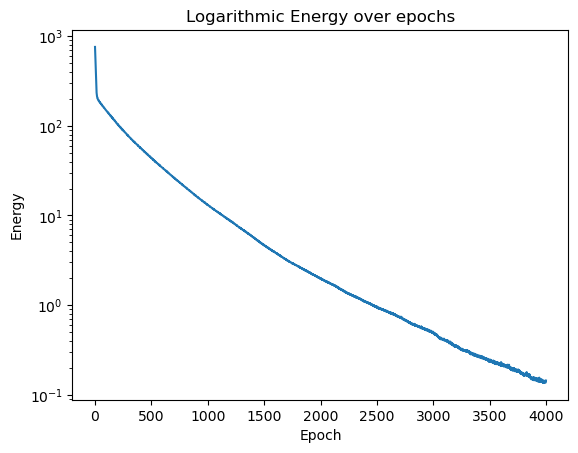

In [ ]:
# plot energy over epochs
plt.plot(energy)
plt.yscale("log")
plt.title("Logarithmic Energy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()


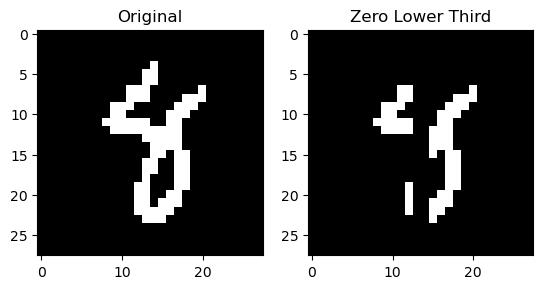

In [ ]:
# Transform to zero lower third of image
def mask_center_column(image, width=0.1):
    image = image.clone()
    image[:, image.shape[1] // 2 - int(image.shape[1] * width) // 2 : image.shape[1] // 2 + int(image.shape[1] * width) // 2] = -1.0
    # image[2 * image.shape[0] // 3:, :] = -1.0
    return image

# Show original and masked image with subplots
fig, ax = plt.subplots(1, 2)
idx = torch.randint(0, len(train_dataset), (1,)).item()
image = train_dataset[idx][0].squeeze().cpu()
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(mask_center_column(image), cmap="gray")
ax[1].set_title("Zero Lower Third")
plt.show()

In [ ]:
len(train_dataset)

480

c:\Users\Joe\anaconda3\envs\ml-env\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":


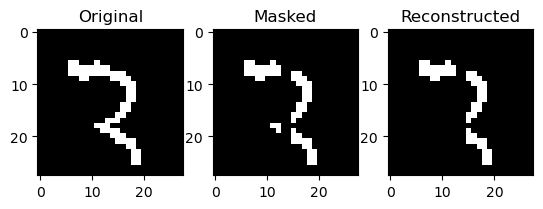

In [27]:
# Test if model can reconstruct masked image

model.to("cpu")
model.eval()

# Get random image from dataset
idx = torch.randint(0, len(train_dataset), (1,)).item()
image = train_dataset[idx][0].squeeze().cpu()
masked_image = mask_center_column(image)

# Convert to tensor and flatten
masked_image = torch.tensor(masked_image)
reconstructed_image = model(masked_image.view(-1), steps=20).view(INPUT_SHAPE)

# Plot original, masked and reconstructed image
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(masked_image, cmap="gray")
ax[1].set_title("Masked")
ax[2].imshow(reconstructed_image.detach().squeeze(0), cmap="gray")
ax[2].set_title("Reconstructed")
plt.show()